## Regression with BIWI head pose dataset

20190109

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [26]:
__version__

'1.0.39'

In [28]:
torch.__version__

'1.0.0'

In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [33]:
from fastai import *
from fastai.vision import *

## Getting and converting the data

In [15]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [16]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [17]:
fname = '09/frame_00667_rgb.jpg'

In [18]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

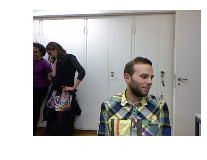

In [19]:
img = open_image(path/fname)
img.show()

In [20]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [21]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [22]:
get_ctr(fname)

tensor([263.9104, 428.5814])

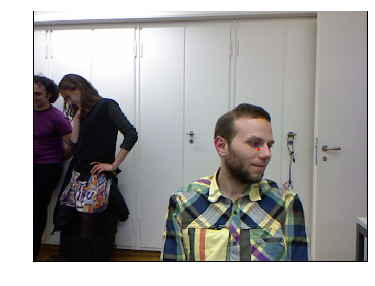

In [23]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

In [24]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13') # single folder validn set
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

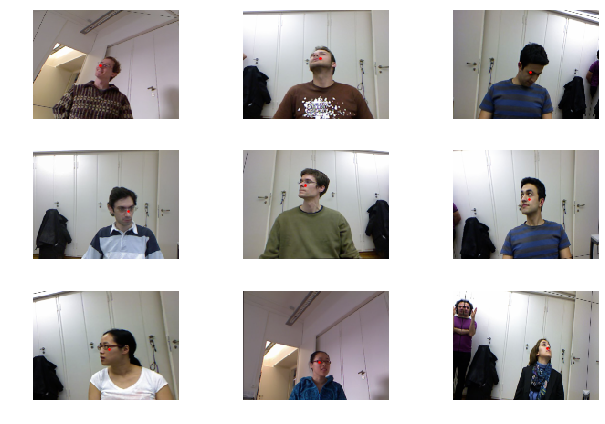

In [29]:
data.show_batch(3, figsize=(9,6))

In [39]:
# the default bs is 64
data.batch_size

64

## Train model

In [30]:
learn = create_cnn(data, models.resnet34)

The lecture used: `learn.loss_func = MSELossFlat()`, here that is done internally by passing `func=MSELoss()` into the attribute `loss_func = fastai.layers.FlattenedLoss`:

In [31]:
learn.loss_func

In [37]:
learn.loss_func.func

MSELoss()

Cross Entropy Loss: *did you predict the correct class, and were you confident of that prediction?*

Can't use CELoss for regression, instead we use Mean Squared Error (difference between the two, squared, added up together).

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


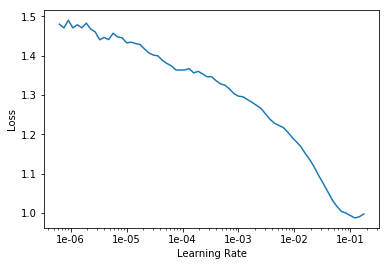

In [38]:
learn.lr_find()
learn.recorder.plot()

In [41]:
lr = 2e-2

In [42]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss
1,0.052509,0.009903
2,0.019312,0.004719
3,0.009242,0.001868
4,0.005782,0.002730
5,0.004077,0.001692


In [43]:
learn.save('stage-1')

In [44]:
learn.load('stage-1');

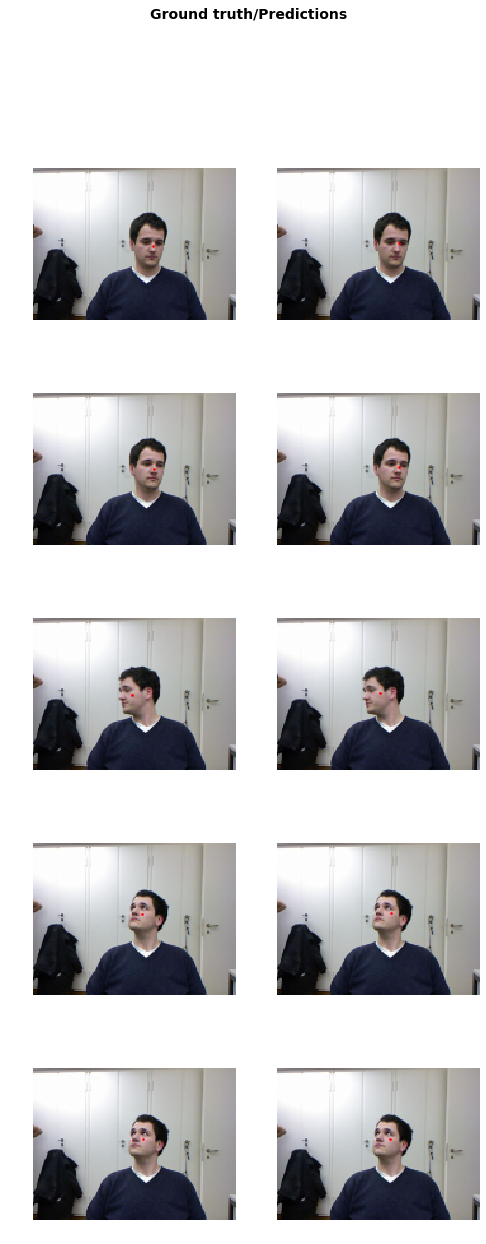

In [47]:
learn.show_results()

## Data augmentation

In [53]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13') # single folder validn set
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160), padding_mode='zeros')
        .databunch().normalize(imagenet_stats)
       )

In [54]:
## Older Datablock API; obsolete
#
# tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)
# data = (ImageItemList.from_folder(path)
#         .split_by_valid_func(lambda o: o.parent.name=='13')
#         .label_from_func(get_ctr, label_cls=PointsItemList)
#         .transform(tfms, tfm_y=True, size=(120,160), padding_mode='zeros')
#         .databunch().normalize(imagenet_stats)
#        )

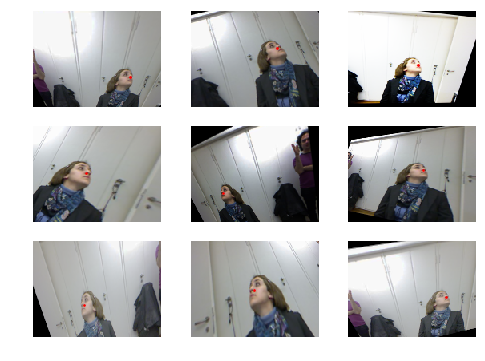

In [55]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))

`padding_mode` options:

- zeros
- border
- reflection

See docs: [vision.transform: Data Augmentation](https://docs.fast.ai/vision.transform.html#Data-augmentation)